# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

# Описание данных

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

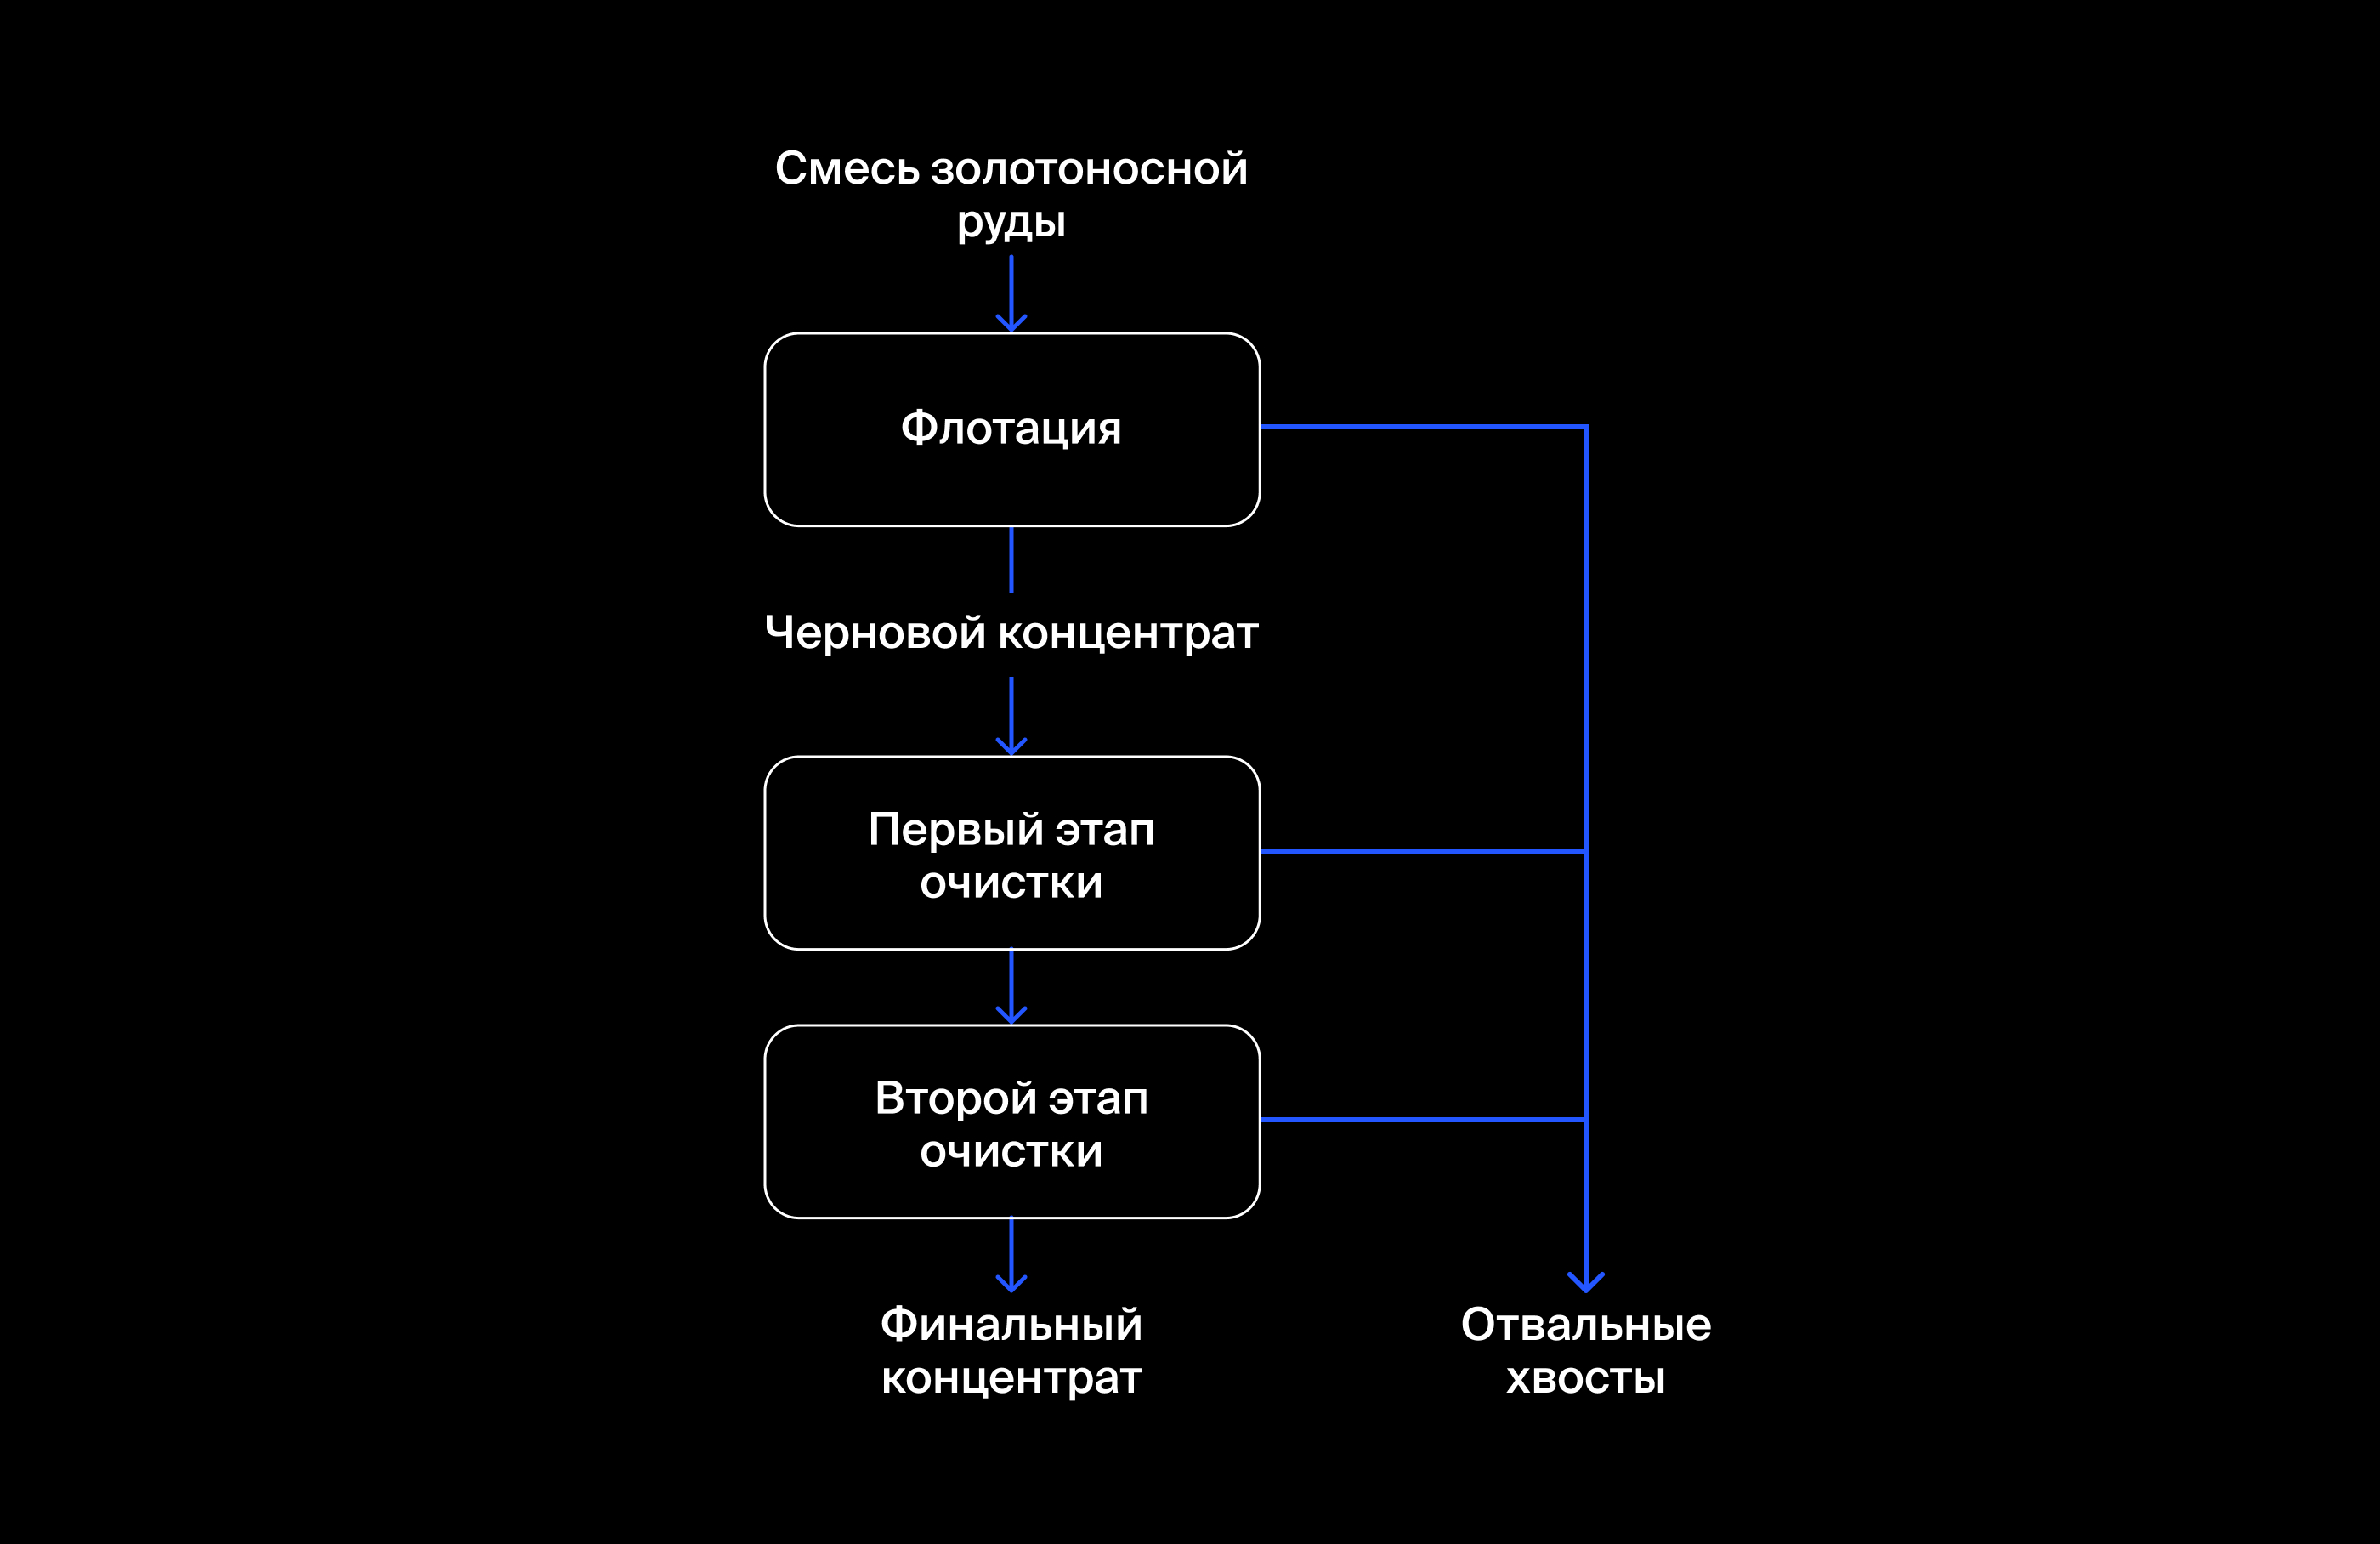

Технологический процесс
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate **— ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота

Параметры этапов
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи
- Наименование признаков

Наименование признаков должно быть такое:
[этап].[тип_параметра].[название_параметра]

Пример: rougher.input.feed_ag
    
Возможные значения для блока [этап]:
- rougher — флотация
- primary_cleaner — первичная очистка
- secondary_cleaner — вторичная очистка
- final — финальные характеристики

Возможные значения для блока [тип_параметра]:
- input — параметры сырья
- output — параметры продукта
- state — параметры, характеризующие текущее состояние этапа
- calculation — расчётные характеристики

## Подготовка данных

In [267]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
%matplotlib inline
import collections

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from scipy import stats as st

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

### Создание класса gold_industry_ml

In [ ]:
class gold_industry_ml():

    ### Создание экземпляра класса

    def __init__(self, df:pd.DataFrame) -> None:
        assert type(df) == pd.core.frame.DataFrame, 'Экземпляр класса должен иметь тип pd.DataFrame'

        try:
            self.data = df
        except:
            'Не получилось создать экземляр класса'

    
    @classmethod
    def instance_from_link(cls,link):
        return gold_industry_ml(
            df=pd.read_csv(link, parse_dates={'datetime' : ['date']}, index_col='datetime')
        )

    ### Расчёт метрик

    @staticmethod
    def recovery_mae(df):
        try:
            df = df.dropna()
            T = df['rougher.output.tail_au']
            F = df['rougher.input.feed_au']
            C = df['rougher.output.concentrate_au']
            target = df['rougher.output.recovery']
            recovery = ((C * (F - T)) / (F * (C - T))) * 100
            result = mean_squared_error(target, recovery)
            result_2 = mean_absolute_error(target,recovery)
            print(f'Метрика mean_squared_error составляет: {result}')
            print(f'Метрика mean_absolute_error составляет: {result_2}')
        except:
            'Недостаточно данных дя расчёта метрики'

    @classmethod
    def columns_diff_research(cls,columns, print_status=True):
        missed_columns_dict = {}
        for colum in columns:
            word_lst = colum.split('.')
            stage = word_lst[0]+'-'+word_lst[1]
            if stage in missed_columns_dict:
                missed_columns_dict[stage].append(word_lst[2])
            elif stage not in missed_columns_dict:
                missed_columns_dict[stage] = [word_lst[2]]
        if print_status:
            for key in missed_columns_dict.keys():
                split_key = key.split('-')
                print('*'*100)
                print(f'ДЛЯ ЭТАПА "{(split_key[0]).upper()}" С ОПЦИЕЙ "{(split_key[1]).upper()}" ОТСУТСТВУЮТ ЗНАЧЕНИЯ:')
                print('*'*100)
                for elem in missed_columns_dict[key]:
                    print(f' - {elem}')

    @staticmethod
    def smape(predict,target):
        result = np.mean((np.abs(predict - target) / ((np.abs(predict) + np.abs(target)) / 2)) * 100)
        return result

    @staticmethod
    def final_smape(rougher_predict, rougher_target, final_predict, final_target):
        result = .25 * gold_industry_ml.smape(rougher_predict, rougher_target) + .75 * gold_industry_ml.smape(final_predict, final_target)
        return result

    ### Проверка данных

    def check_duplicated(self):
        print(f'Количество дубликатов: {self.data.duplicated().sum()}')

    def check_misses(self, print_status=True):
        misses = pd.DataFrame(self.data.isna().sum().sort_values(ascending=False), columns=['misses'])
        misses['per'] = self.data.isna().mean().sort_values(ascending=False).apply(lambda x : '{:.2%}'.format(x))
        misses = misses.loc[misses['misses'] > 0]
        if print_status:
            try:
                misses_rov = self.data['rougher.output.recovery'].isna().mean()
                misses_for = self.data['final.output.recovery'].isna().mean()
                print(f'Количество пропусков в целом признаке "rougher.output.recovery" составляет: {misses_rov}')
                print(f'Количество пропусков в целом признаке "final.output.recovery" составляет: {misses_for}')
            except:
                print('Целевого признака в данных не найдено')
        if misses.shape[0] > 0:
            return misses
        else:
            print('Пропусков в данных нет')

    ### Обработка данных

    def processing_misses(self):
        self.data = self.data.interpolate()

    ### plots
    
    @staticmethod
    def plot_density_hist(df_train, df_test):
        plt.figure(figsize=[15, 12])
        plt.title('График распределения гранул исходного сырья:', fontsize=15)
        sns.histplot(df_train, stat='density', color='powderblue', alpha=0.6,legend=True)
        sns.histplot(df_test, stat='density', color='gold', alpha=0.6,legend=True)
        plt.legend()

    def plot_hist_by_steps(self):
        position = 0
        plt.figure(figsize=[15, 17])
        sns.set_theme(style='ticks')
        plt.subplots_adjust(top=0.94, wspace=0.2, hspace=0.3)
        for step in ['au', 'ag', 'pb']:
            position += 1
            plt.subplot(3, 1, position)
            step_split = step.split('.')
            plt.title(f'Металл {step_split}', fontsize=13)
            sns.histplot(self.data[f'rougher.input.feed_{step}'], color='gold', label='rougher.input')
            sns.histplot(self.data[f'rougher.output.concentrate_{step}'], color='silver', label='rougher.output')
            sns.histplot(self.data[f'primary_cleaner.output.concentrate_{step}'], color='powderblue', label='primary_cleaner')
            sns.histplot(self.data[f'final.output.concentrate_{step}'], color='orange', label='final.output')
            median_rougher_input = self.data[f'rougher.input.feed_{step}'].median()
            median_rougher_output = self.data[f'rougher.output.concentrate_{step}'].median()
            median_primary_cleaner = self.data[f'primary_cleaner.output.concentrate_{step}'].median()
            median_final_output = self.data[f'final.output.concentrate_{step}'].median()
            plt.text(median_rougher_input + 0.1, 50, round(median_rougher_input,2),fontsize=12)
            plt.text(median_rougher_output + 0.1, 50, round(median_rougher_output,2),fontsize=12)
            plt.text(median_primary_cleaner + 0.1, 50, round(median_primary_cleaner,2),fontsize=12)
            plt.text(median_final_output + 0.1, 50, round(median_final_output,2),fontsize=12)
            plt.axvline(median_rougher_input, color='green', linestyle='--', label="median_rougher_input", alpha=0.6)
            plt.axvline(median_rougher_output, color='green', linestyle='--', label="median_rougher_output", alpha=0.6)
            plt.axvline(median_primary_cleaner, color='green', linestyle='--', label="median_primary_cleaner",alpha=0.6)
            plt.axvline(median_final_output, color='green', linestyle='--', label="median_final_output",alpha=0.6)
            plt.xlabel('Концентрация металла')
            plt.ylabel('Количество наблюдений')
            plt.legend()
        plt.show()
        
    
    def plot_hist_by_sum(self):
        plt.figure(figsize=[15, 12])
        plt.title('Суммарная концентрация метаталлов на разных этапах отчистки:', fontsize=15)
        df = pd.DataFrame()
        for step in ['rougher.input.feed', 'rougher.output.concentrate','primary_cleaner.output.concentrate','final.output.concentrate']:
            df[step] = self.data[f'{step}_au'] + self.data[f'{step}_ag'] + self.data[f'{step}_pb']
        sns.histplot(df, legend=True)
        median_rougher_input = df['rougher.input.feed'].median()
        median_rougher_output = df['rougher.output.concentrate'].median()
        median_primary_cleaner = df['primary_cleaner.output.concentrate'].median()
        median_final = df['final.output.concentrate'].median()
        plt.text(median_rougher_input + 0.1, 50, round(median_rougher_input,2),fontsize=12)
        plt.text(median_rougher_output + 0.1, 50, round(median_rougher_output,2),fontsize=12)
        plt.text(median_primary_cleaner + 0.1, 50, round(median_primary_cleaner,2),fontsize=12)
        plt.text(median_final + 0.1, 50, round(median_final,2),fontsize=12)
        plt.axvline(median_rougher_input, color='green', linestyle='--', label="median_rougher_input", alpha=0.6)
        plt.axvline(median_rougher_output, color='green', linestyle='--', label="median_rougher_output", alpha=0.6)
        plt.axvline(median_primary_cleaner, color='green', linestyle='--', label="median_primary_cleaner", alpha=0.6)
        plt.axvline(median_final, color='green', linestyle='--', label="median_final", alpha=0.6)

    
    ### ML

    def features_target_splitter(self, by_steps=True, step='rougher'):
        self.features = self.data.drop(columns=['final.output.recovery','rougher.output.recovery'])
        self.target = self.data[['final.output.recovery','rougher.output.recovery']]
        if by_steps:
            self.target_rougher = self.data['rougher.output.recovery']
            self.target_final = self.data['final.output.recovery']
            new_col = [i for i in self.features if ((i.split('.')[0]=='rougher') & (i.split('.')[-1] != 'recovery'))]
            self.features_rougher = self.data[new_col]
            




    @staticmethod
    def __def_pipeline_param():
        
        score = make_scorer(gold_industry_ml.smape, greater_is_better=False)
        
        pipe = Pipeline(
            [
                ('imputer', SimpleImputer()),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression),
            ]
        )

        param_grid = [
            {
                'regressor':[LinearRegression()],
            },
            {
                'regressor':[RandomForestRegressor(random_state=42)],
                'regressor__n_estimators':[5,10,15,25],
                'regressor__max_depth':[5,10,15,30],
            },
            {
                'regressor':[DecisionTreeRegressor()],
                'regressor__max_depth' : [10,15,25,50]
            }
        ]
        
        return score, pipe, param_grid
        
    
    @classmethod
    def fit_pipepline_target_rougher(cls, features, target):

        score, pipe, param_grid = gold_industry_ml.__def_pipeline_param()
        
        cls.rougher_pipeline = GridSearchCV(
            pipe,
            param_grid=param_grid,
            cv=5,
            verbose=3,
            scoring=score,
            return_train_score=True
        )

        cls.rougher_pipeline.fit(features,target)
        
    @classmethod
    def fit_pipepline_target_final(cls, features, target):

        score, pipe, param_grid = gold_industry_ml.__def_pipeline_param()
        
        cls.final_pipeline = GridSearchCV(
            pipe,
            param_grid=param_grid,
            cv=5,
            verbose=3,
            scoring=score,
            return_train_score=True
        )

        cls.final_pipeline.fit(features,target)

    @classmethod
    def use_pipeline_rougher(cls, features):
        predict = gold_industry_ml.rougher_pipeline.predict(features)     
        return predict
    
    def predict_rougher(self):
        self.predict_rougher = gold_industry_ml.rougher_pipeline.predict(self.features_rougher)
        self.score_rougher = gold_industry_ml.smape(self.target_rougher, self.predict_rougher)
    
    @classmethod
    def use_pipeline_final(cls, features):
        predict = gold_industry_ml.final_pipeline.predict(features)
        return predict
    
    def predict_final(self):
        self.predict_final = gold_industry_ml.final_pipeline.predict(self.features)
        self.score_final = gold_industry_ml.smape(self.target_final, self.predict_final)
        
    def predict_all_with_smape_final_score(self):
        self.predict_rougher = gold_industry_ml.rougher_pipeline.predict(self.features_rougher)
        self.score_rougher = gold_industry_ml.smape(self.target_rougher, self.predict_rougher)
        self.predict_final = gold_industry_ml.final_pipeline.predict(self.features)
        self.score_final = gold_industry_ml.smape(self.target_final, self.predict_final)
        self.total_smape = gold_industry_ml.final_smape(self.predict_rougher, self.target_rougher, self.predict_final, self.target_final)

In [269]:
data_full = gold_industry_ml.instance_from_link('https://code.s3.yandex.net/datasets/gold_industry_full.csv')
data_train = gold_industry_ml.instance_from_link('https://code.s3.yandex.net/datasets/gold_industry_train.csv')
data_test = gold_industry_ml.instance_from_link('https://code.s3.yandex.net/datasets/gold_industry_test.csv')

In [270]:
data_full.data.info(verbose=False)
print('Индекс расположен по порядку: {}'.format(data_full.data.index.is_monotonic_increasing))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Columns: 86 entries, rougher.input.feed_au to final.output.tail_sol
dtypes: float64(86)
memory usage: 12.9 MB
Индекс расположен по порядку: True


In [271]:
data_train.data.info(verbose=False)
print('Индекс расположен по порядку: {}'.format(data_train.data.index.is_monotonic_increasing))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14579 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Columns: 86 entries, rougher.input.feed_au to final.output.tail_sol
dtypes: float64(86)
memory usage: 9.7 MB
Индекс расположен по порядку: True


In [272]:
data_test.data.info(verbose=False)
print('Индекс расположен по порядку: {}'.format(data_test.data.index.is_monotonic_increasing))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4860 entries, 2017-12-09 14:59:59 to 2018-08-18 10:59:59
Columns: 52 entries, rougher.input.feed_au to secondary_cleaner.state.floatbank6_a_level
dtypes: float64(52)
memory usage: 2.0 MB
Индекс расположен по порядку: True


### Вывод:

Имеется три набора данных: 

1) `data_full` - полный датасет с данными за период с `2016-01-15` по `2018-08-18`. Имеет 19439 строки и 86 колонок;
2) `data_train` - тренировочный датасет с данными за период с `2016-01-15` по `2017-12-09`. Имеет 14579 строки и  86 колонок;
3) `data_test` - тестовый датасет с данными за период с `2017-12-09` по `2018-08-18`. Имеет 4860 строки и 52 колонок.

Таким образом, можно сделать вывод, что:

* `data_full` делится на два сета, первый `data_train`, который включает в себя `74.99%` данных по `2017-12-09`. Второй - `data_test`, которые включается оставшиеся данные - `25%`. Стоит отметить, что данные имеют лишь `52` колонки, что свидетельствует о том, что некоторые данные недоступны при осуществлении прогноза.

## Recovery

![image.png](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg)

где:
* C — доля золота в концентрате после флотации/очистки;
* F — доля золота в сырье/концентрате до флотации/очистки;
* T — доля золота в отвальных хвостах после флотации/очистки.

In [273]:
gold_industry_ml.recovery_mae(data_train.data)

Метрика mean_squared_error составляет: 2.2198777345439083e-28
Метрика mean_absolute_error составляет: 9.906677443564516e-15


### Вывод:

`Mean_absolute_error` составляет $9.91e-15$,  что свидетельствует о том, что параметр `recovery` рассчитан верно.

## Разница в признаках

In [274]:
gold_industry_ml.columns_diff_research(set(data_train.data).difference(data_test.data))

****************************************************************************************************
ДЛЯ ЭТАПА "PRIMARY_CLEANER" С ОПЦИЕЙ "OUTPUT" ОТСУТСТВУЮТ ЗНАЧЕНИЯ:
****************************************************************************************************
 - tail_pb
 - concentrate_ag
 - concentrate_sol
 - tail_sol
 - concentrate_pb
 - concentrate_au
 - tail_ag
 - tail_au
****************************************************************************************************
ДЛЯ ЭТАПА "ROUGHER" С ОПЦИЕЙ "OUTPUT" ОТСУТСТВУЮТ ЗНАЧЕНИЯ:
****************************************************************************************************
 - tail_sol
 - tail_pb
 - tail_ag
 - concentrate_sol
 - concentrate_ag
 - tail_au
 - concentrate_au
 - concentrate_pb
 - recovery
****************************************************************************************************
ДЛЯ ЭТАПА "ROUGHER" С ОПЦИЕЙ "CALCULATION" ОТСУТСТВУЮТ ЗНАЧЕНИЯ:
******************************************************

### Вывод:

В тестовых данных отсутствуют 34 колонки:

* Отсутствуют все остатки после обработки на всех этапах - `tail_pb`,`tail_sol`,`tail_au`,`tail_ag`;
* Также отсутствует информация концентрации металлов для этапов - `final`,`primary_cleaner`,`rougher`,`secondary_cleaner`;
* Помимо прочего в тестовых данных не содержаться целевые признаки: `rougher.output.recovery` и `final.output.recovery`.

Из условия задачи известно, что признаки из тестовых данных это все признаки, которые будут доступны при прогнозировании. Следовательно:
* Из обучающей выборки необходимо удалить все недоступные при тестировании признаки;
* В тестовые данные необходимо добавить целевые признаки.

## Предобработка данных

### Дубликаты

In [275]:
data_full.check_duplicated()

Количество дубликатов: 0


In [276]:
data_train.check_duplicated()

Количество дубликатов: 0


In [277]:
data_test.check_duplicated()

Количество дубликатов: 0


### Пропуски

In [278]:
data_train.check_misses().head(10)

Количество пропусков в целом признаке "rougher.output.recovery" составляет: 0.0
Количество пропусков в целом признаке "final.output.recovery" составляет: 0.0


,misses,per
secondary_cleaner.output.tail_sol,920,6.31%
rougher.state.floatbank10_e_air,429,2.94%
rougher.input.floatbank11_xanthate,407,2.79%
primary_cleaner.output.concentrate_sol,265,1.82%
final.output.concentrate_sol,192,1.32%
rougher.input.feed_size,101,0.69%
secondary_cleaner.state.floatbank2_a_air,94,0.64%
primary_cleaner.output.concentrate_pb,88,0.60%
rougher.input.feed_sol,77,0.53%
final.output.tail_pb,75,0.51%


In [279]:
data_test.check_misses().head(10)

Целевого признака в данных не найдено


,misses,per
secondary_cleaner.state.floatbank2_a_air,126,2.59%
rougher.input.floatbank11_xanthate,46,0.95%
rougher.input.feed_size,44,0.91%
primary_cleaner.input.xanthate,43,0.88%
rougher.input.feed_pb,28,0.58%
rougher.input.feed_sol,22,0.45%
primary_cleaner.input.depressant,9,0.19%
rougher.input.floatbank11_sulfate,8,0.16%
rougher.state.floatbank10_e_air,7,0.14%
rougher.input.feed_rate,4,0.08%


In [280]:
data_full.check_misses().head(10)

Количество пропусков в целом признаке "rougher.output.recovery" составляет: 0.0
Количество пропусков в целом признаке "final.output.recovery" составляет: 0.0


,misses,per
secondary_cleaner.output.tail_sol,1748,8.99%
rougher.input.floatbank11_xanthate,453,2.33%
rougher.state.floatbank10_e_air,436,2.24%
primary_cleaner.output.concentrate_sol,370,1.90%
secondary_cleaner.state.floatbank2_a_air,220,1.13%
final.output.concentrate_sol,211,1.09%
rougher.input.feed_size,145,0.75%
primary_cleaner.output.concentrate_pb,116,0.60%
primary_cleaner.input.xanthate,104,0.54%
final.output.tail_pb,101,0.52%


### Аномалии

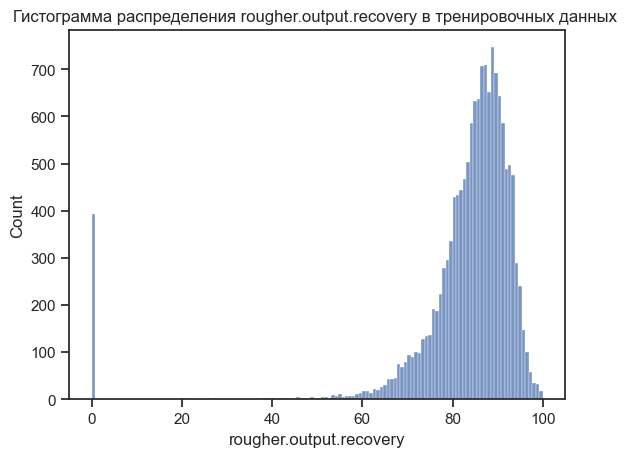

In [281]:
sns.histplot(data=data_train.data['rougher.output.recovery'])
plt.title('Гистограмма распределения rougher.output.recovery в тренировочных данных ')
plt.show()

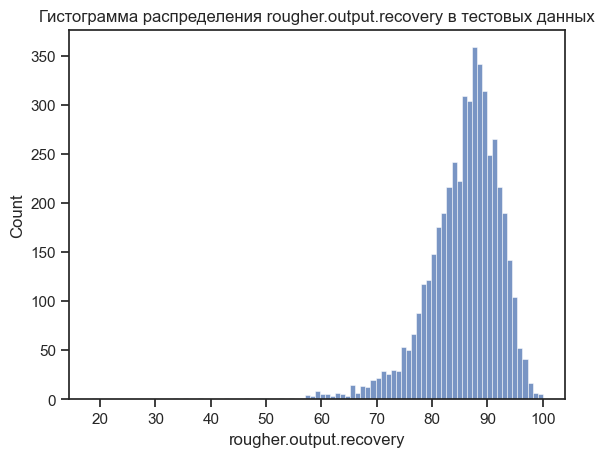

In [282]:
sns.histplot(data=data_full.data.loc[data_test.data.index, 'rougher.output.recovery'])
plt.title('Гистограмма распределения rougher.output.recovery в тестовых данных')
plt.show()

### Вывод:

* Дубликатов в данных не обнаружено;
* В трех выборках обнаружено разное количество пропусков;
* В целевых признаках пропусков не обнаружено;
* Обнаружены выбросы в обучающей выборке.
  
Исходя из обнаруженных проблем, нужно совершить следующие действия: 

* Необходимо заполнить пропуски. Вариантов заполнения несколько:
    - Заполнения каким-либо показателем - средним, медианным и так далее;
    - Так как данные, которые расположены близко по времени, являются и близкими по значению, то можно воспользоваться методом `interpolate()`. Однако в таком случае оценка будет завышена, поскольку данные будут также браться из будущих значений, которых на практике не будет;
    - Заполнить значения ближайшими предыдущими доступными значениями.
* Выбросы удалить (если есть на то основания) или оставить. 

## Анализ данных

### Концентрация элементов на каждом этапе

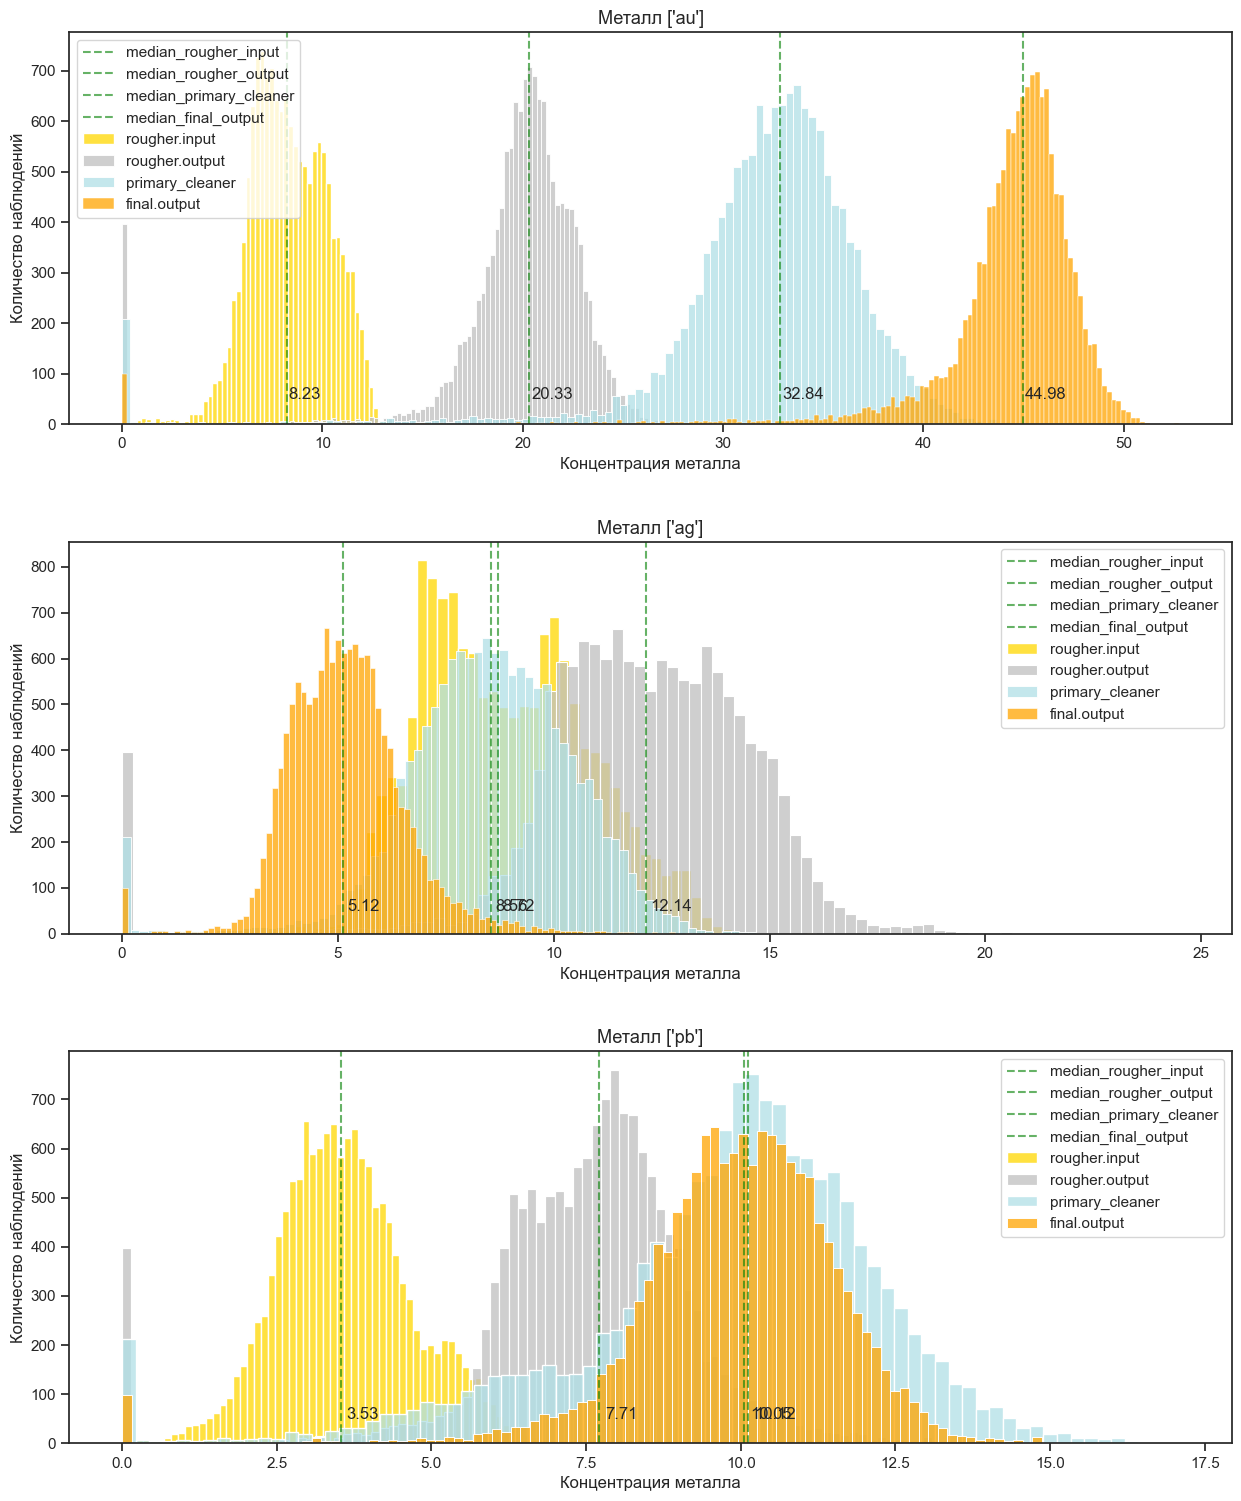

In [283]:
data_train.plot_hist_by_steps()

### Вывод:

* На каждом этапе концентрация золота увеличивается. Так, на первом этапе медианное значение составляло `8.23`, в то время как на финальном этапе концентрация золота уже составляет `44.98`;
* Концентрация свинца из этапа к этапу также растет, однако на порядок медленнее, чем растет концентрация золота. На начальном этапе `3.53`, на конечном - `10.05`;
* Концентрация серебра снижается и к последнему этапу составляет `5.12`, против начальных `8.72`.

### Распределения размеров гранул на обучающей и тестовой выборках

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


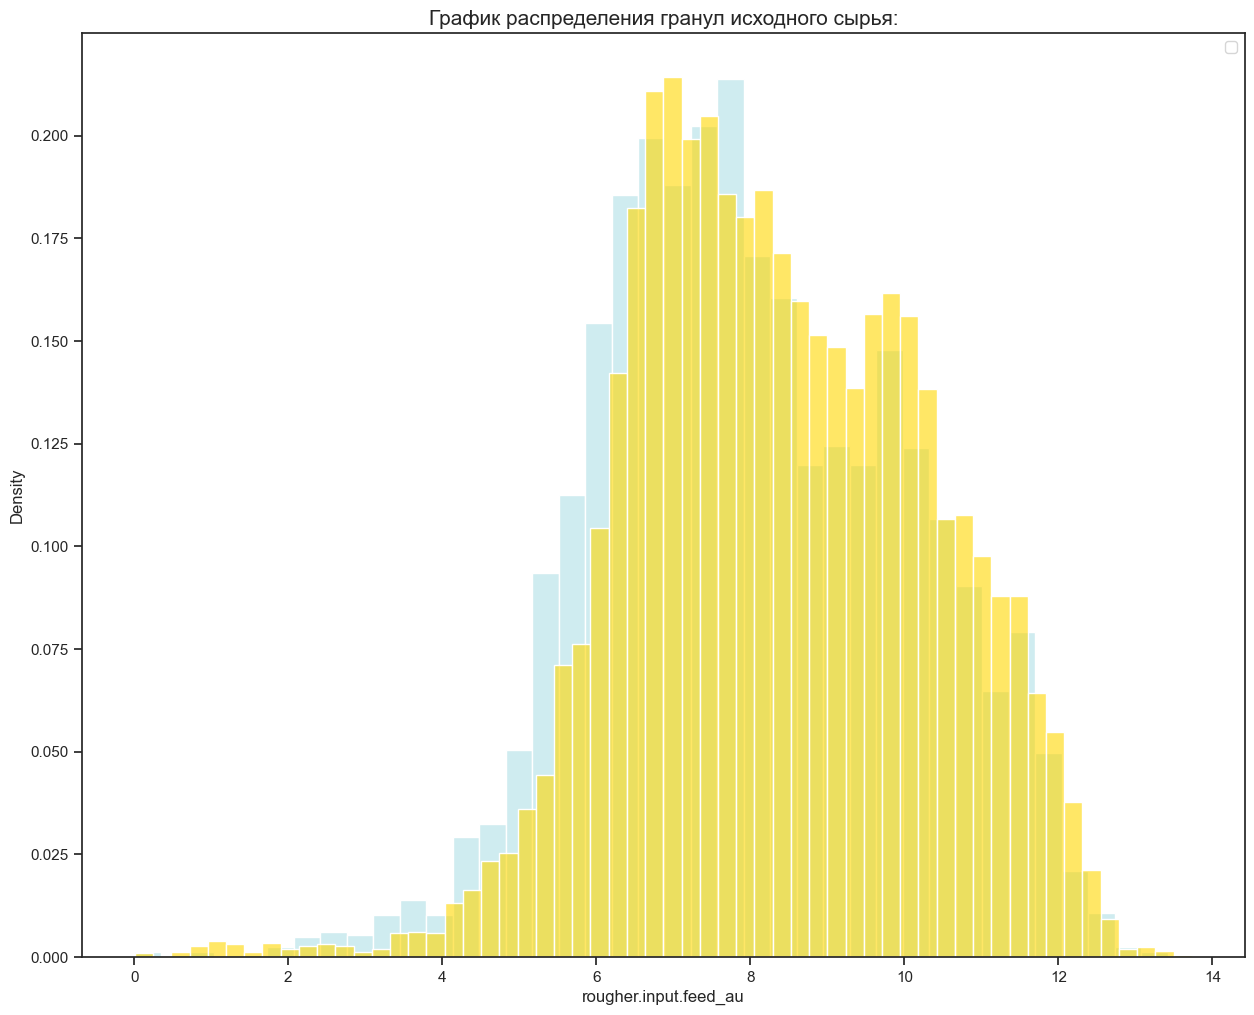

In [284]:
gold_industry_ml.plot_density_hist(data_test.data['rougher.input.feed_au'],data_train.data['rougher.input.feed_au'])

### Вывод:

* Выборки имеют схожее распределение.

### Суммарная концентрация метаталлов

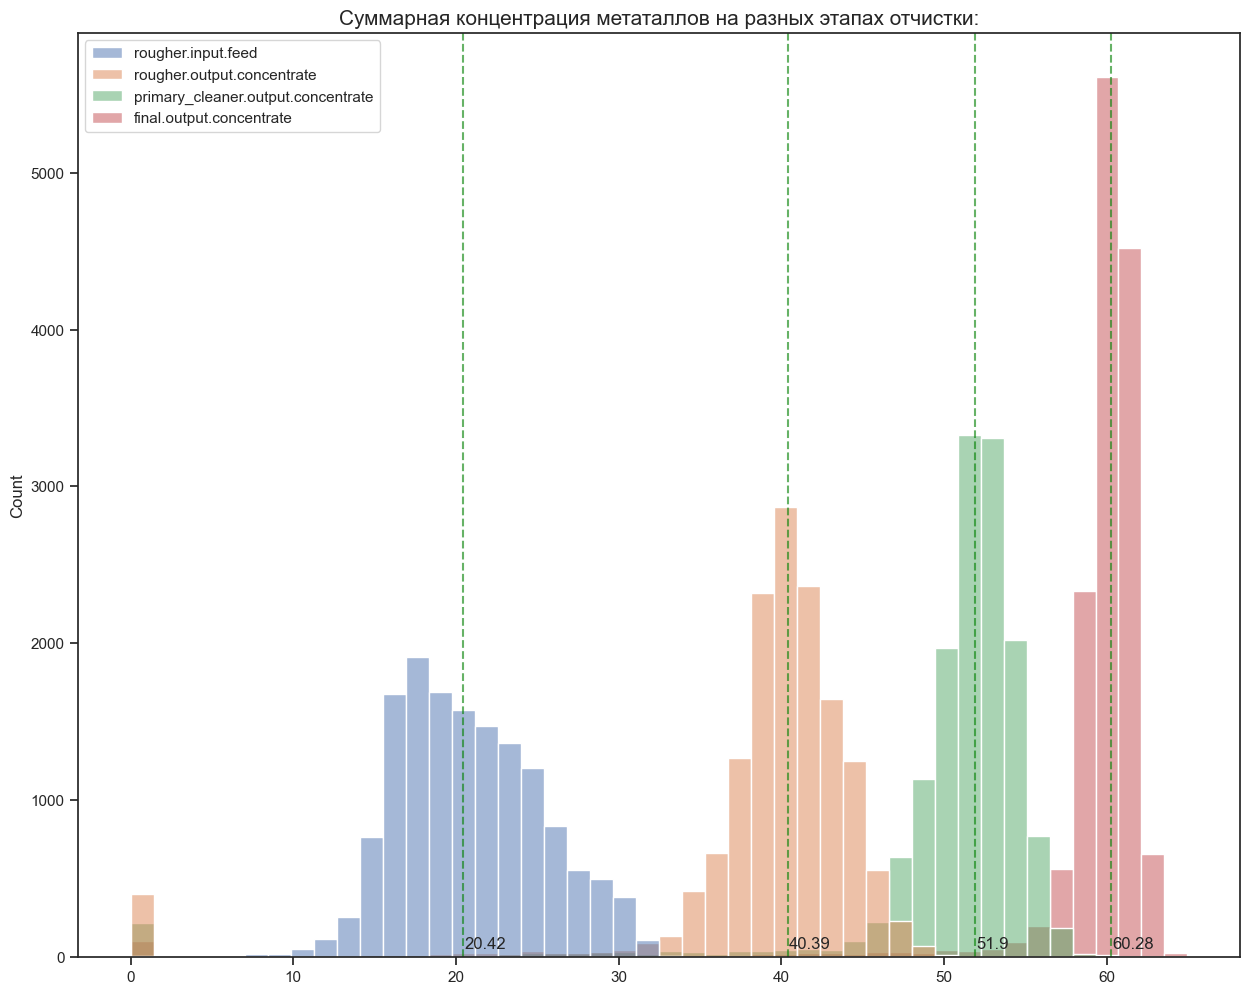

In [285]:
data_train.plot_hist_by_sum()

### Вывод:

* Суммарная концентрация металлов возрастает с `20.42` на этапе сырья до `60.28` на финальном этапе;
* Имеется пик возле нулевого значения. Возможные причины: объективные и технические ошибки. Удалим аномалии:
  


In [286]:
for step in ['rougher.input.feed', 'rougher.output.concentrate','primary_cleaner.output.concentrate','final.output.concentrate']:
    sum = data_train.data[f'{step}_au'] + data_train.data[f'{step}_ag'] + data_train.data[f'{step}_pb']
    print('Количество записей, где суммарное количество веществ не превышает .1 на шаге {}: {}'.format(step, len(sum.loc[sum < .1])))
    data_train.data = data_train.data.drop(sum.loc[sum < 10].index, axis=0)

Количество записей, где суммарное количество веществ не превышает 1 на шаге rougher.input.feed: 3
Количество записей, где суммарное количество веществ не превышает 1 на шаге rougher.output.concentrate: 391
Количество записей, где суммарное количество веществ не превышает 1 на шаге primary_cleaner.output.concentrate: 201
Количество записей, где суммарное количество веществ не превышает 1 на шаге final.output.concentrate: 87


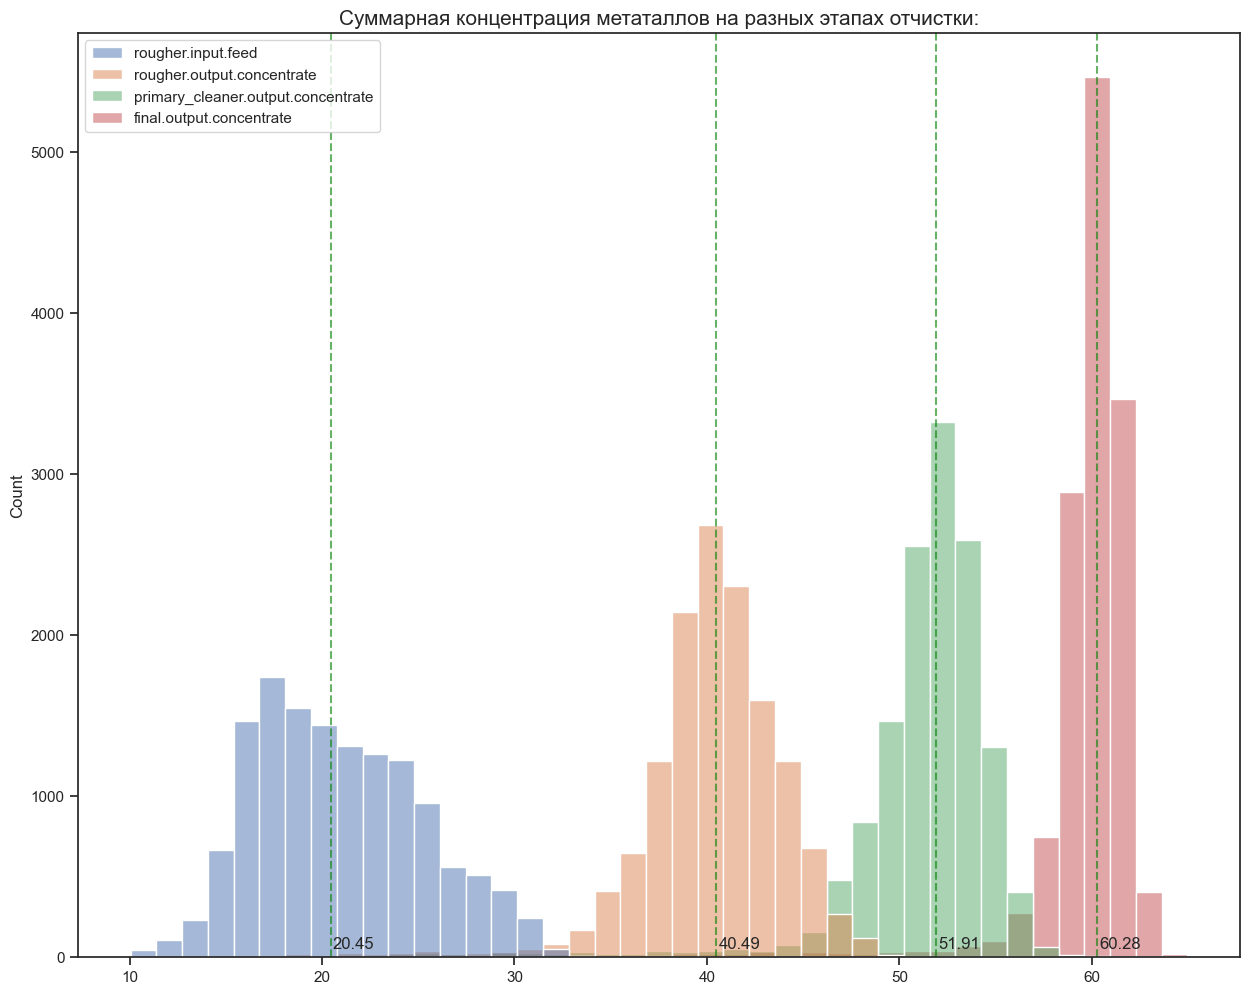

In [287]:
data_train.plot_hist_by_sum()

## Построение модели

### Обучение модели

Выделим колонки из тестовых данных, добавив в них целевой признак. Получим признаки для обучения различных регрессионных моделей.

In [288]:
new_columns = list(data_test.data.columns)
new_columns.extend(['final.output.recovery','rougher.output.recovery'])
new_columns.sort()

In [289]:
data_test = gold_industry_ml(data_full.data.loc[data_test.data.index, new_columns])
data_train = gold_industry_ml(data_full.data.loc[data_train.data.index, new_columns])

Разделим выборки на признаки и целевые признаки. Так как в нашей задаче два целевых признака, обучим модели с различными наборами признаков:

1. Для этапа `rougher` только с признаками, которые относятся к данному этапу;
2. Для этапа `final` со всеми доступными признаками.

In [290]:
data_test.features_target_splitter()
data_train.features_target_splitter()
data_train.features_target_splitter()
data_test.features_target_splitter()

Для оценки модели будем использовать метрику `sMAPE`:

![image.png](https://pictures.s3.yandex.net/resources/smape_1576238825.jpg)

Обучим модель для этапа `rougher`:

In [291]:
data_train.features_rougher.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13799 entries, 2016-01-15 00:00:00 to 2017-12-09 13:59:59
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   rougher.input.feed_ag               13799 non-null  float64
 1   rougher.input.feed_au               13799 non-null  float64
 2   rougher.input.feed_pb               13759 non-null  float64
 3   rougher.input.feed_rate             13793 non-null  float64
 4   rougher.input.feed_size             13704 non-null  float64
 5   rougher.input.feed_sol              13741 non-null  float64
 6   rougher.input.floatbank10_sulfate   13780 non-null  float64
 7   rougher.input.floatbank10_xanthate  13798 non-null  float64
 8   rougher.input.floatbank11_sulfate   13776 non-null  float64
 9   rougher.input.floatbank11_xanthate  13450 non-null  float64
 10  rougher.state.floatbank10_a_air     13799 non-null  float64
 11  roughe

In [292]:
gold_industry_ml.fit_pipepline_target_rougher(data_train.features_rougher, data_train.target_rougher)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END regressor=LinearRegression();, score=(train=-3.924, test=-8.476) total time=   0.0s
[CV 2/5] END regressor=LinearRegression();, score=(train=-4.738, test=-5.935) total time=   0.0s
[CV 3/5] END regressor=LinearRegression();, score=(train=-4.993, test=-4.934) total time=   0.0s
[CV 4/5] END regressor=LinearRegression();, score=(train=-4.937, test=-4.669) total time=   0.0s
[CV 5/5] END regressor=LinearRegression();, score=(train=-4.560, test=-9.722) total time=   0.0s
[CV 1/5] END regressor=RandomForestRegressor(random_state=42), regressor__max_depth=5, regressor__n_estimators=5;, score=(train=-3.506, test=-8.261) total time=   0.4s
[CV 2/5] END regressor=RandomForestRegressor(random_state=42), regressor__max_depth=5, regressor__n_estimators=5;, score=(train=-3.960, test=-5.107) total time=   0.4s
[CV 3/5] END regressor=RandomForestRegressor(random_state=42), regressor__max_depth=5, regressor__n_estimators=5;, sc

Обучим модель для этапа `final`:

In [293]:
gold_industry_ml.fit_pipepline_target_final(data_train.features, data_train.target_final)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV 1/5] END regressor=LinearRegression();, score=(train=-7.365, test=-10.876) total time=   0.3s
[CV 2/5] END regressor=LinearRegression();, score=(train=-7.870, test=-8.320) total time=   0.1s
[CV 3/5] END regressor=LinearRegression();, score=(train=-7.617, test=-8.573) total time=   0.1s
[CV 4/5] END regressor=LinearRegression();, score=(train=-7.632, test=-8.951) total time=   0.0s
[CV 5/5] END regressor=LinearRegression();, score=(train=-7.541, test=-11.639) total time=   0.0s
[CV 1/5] END regressor=RandomForestRegressor(random_state=42), regressor__max_depth=5, regressor__n_estimators=5;, score=(train=-6.644, test=-9.673) total time=   0.9s
[CV 2/5] END regressor=RandomForestRegressor(random_state=42), regressor__max_depth=5, regressor__n_estimators=5;, score=(train=-7.247, test=-7.072) total time=   0.9s
[CV 3/5] END regressor=RandomForestRegressor(random_state=42), regressor__max_depth=5, regressor__n_estimators=5;, 

Лучшие модели имеют следующие параметры:

In [294]:
gold_industry_ml.rougher_pipeline.best_params_

{'regressor': RandomForestRegressor(max_depth=5, n_estimators=5, random_state=42),
 'regressor__max_depth': 5,
 'regressor__n_estimators': 5}

In [295]:
gold_industry_ml.final_pipeline.best_params_

{'regressor': RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42),
 'regressor__max_depth': 5,
 'regressor__n_estimators': 10}

In [296]:
print('финальная оценка sMAPE лучшей модели составляет: {:.3}'
      .format(abs(gold_industry_ml.final_pipeline.best_score_) * .75 + abs(gold_industry_ml.rougher_pipeline.best_score_) * .25))

финальная оценка sMAPE лучшей модели составляет: 8.18


### Вывод:

В результате с помощью конвеиера pipeline:

1. Данные были обработаны: заполнены пропуски, признаки были отскалированы; 
2. C помощью `gridsearchcv` были обнаружены наилучшие параметры моделей (использовалась оценка sMAPE);
3. Модель и её гиперпараметры для двух целевых показателей: 
   - `RandomForestRegressor`  с параметрами `max_depth` - $5$ и `n_estimators` - $10$ для этапа `final`;
   - `RandomForestRegressor`  с параметрами `max_depth` - $5$ и `n_estimators` - $5$ для этапа `rougher`.

### Тестирование модели

Получим предсказанные значения:

In [297]:
data_test.predict_all_with_smape_final_score()

In [298]:
print('Лучшая оценка для этапа "rougher": {:.3}'.format(data_test.score_rougher))

Лучшая оценка для этапа "rougher": 4.07


Лучшая оценка для этапа `final`:

In [299]:
print('Лучшая оценка для этапа "final": {:.3}'.format(data_test.score_final))

Лучшая оценка для этапа "final": 7.52


Финальная оценка `sMAPE`, которая рассчитывается следующим образом:

![image.png](https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg)

составляет:

In [300]:
print('Финальная оценка total_smape: {:.3}'.format(data_test.total_smape))

Финальная оценка total_smape: 6.66


Проверим модель на адекватность, сравнив результат с моделью `DummyRegressor`:

### DummyRegressor

In [301]:
dummy_rougher = DummyRegressor(strategy='mean')
dummy_final = DummyRegressor(strategy='mean')

dummy_rougher.fit(data_train.features_rougher, data_train.target_rougher)
dummy_final.fit(data_train.features, data_train.target_final)

rougher = dummy_rougher.predict(data_test.features_rougher)
final = dummy_final.predict(data_test.features)

print('Итоговая оценка sMAPE для DummyRegressor составила: {:.3}'.format(gold_industry_ml.final_smape(rougher,
                                                                                data_test.target_rougher,
                                                                                final,
                                                                                data_test.target_final)))

Итоговая оценка sMAPE для DummyRegressor составила: 8.45


### Вывод

Таким образом, можно заключить, что модель прошла тест на адекватность. `RandomForestRegressor` имеют финальную ошибку `sMAPE`: `6.66`, в то время как `DummyRegressor` имеет ошибку `8.45`.

## Вывод

a. Подготовка данных

1. Была получена первичная информация о доступных датасетах: 
* `data_full` - полный датасет с данными за период с `2016-01-15` по `2018-08-18`. Имеет 19439 строки и 86 колонок;
* `data_train` - тренировочный датасет с данными за период с `2016-01-15` по `2017-12-09`. Имеет 14579 строки и  86 колонок;
* `data_test` - тестовый датасет с данными за период с `2017-12-09` по `2018-08-18`. Имеет 4860 строки и 52 колонок.

Различие в колонках, исходя из условия задачи, объясняется доступностью признаков при прогнозе.

2. Был рассчитан параметр `recovery`  и посчитана `mean_absolute_error`, которая составила $9.91e-15$. Это свидетельствует о том, что параметр в датасете рассчитан верно. 

3. Была определена разница в признаках между обучающей и тестовой выборкой. Было выявлено, что в тестовых данных отсутствуют 34 колонки:

* Отсутствуют все остатки после обработки на всех этапах - `tail_pb`,`tail_sol`,`tail_au`,`tail_ag`;
* Также отсутствует информация концентрации металлов для этапов - `final`,`primary_cleaner`,`rougher`,`secondary_cleaner`;
* Помимо прочего в тестовых данных не содержаться целевые признаки: `rougher.output.recovery` и `final.output.recovery`.

Были выявлены необходимые пути решения проблем:
Из условия задачи известно, что признаки из тестовых данных это все признаки, которые будут доступны при прогнозировании. Следовательно:
* Из обучающей выборки необходимо удалить все недоступные при тестировании признаки;
* В тестовые данные необходимо добавить целевые признаки.

4. Данные были проверены на дубликаты и пропуски. Дубликаты и пропуски в целевых признаках отсутствовали. Присутствовало множество пропусков в признаках.

b. Анализ данных

1. Была разобрана концентрация элементов на каждом этапе. 

* На каждом этапе концентрация золота увеличивается. Так, на первом этапе медианное значение составляло `8.23`, в то время как на финальном этапе концентрация золота уже составляет `44.98`;
* Концентрация свинца из этапа к этапу также растет, однако на порядок медленнее, чем растет концентрация золота. На начальном этапе `3.53`, на конечном - `10.05`;
* Концентрация серебра снижается и к последнему этапу составляет `5.12`, против начальных `8.72`.

2. Были разобраны распределения размеров гранул на обучающей и тестовой выборках. Распределения отличаются не сильно и, как следствие, оценка модели будет адекватной;
   
3. Была разобрана суммарная концентрация металлов на различных этапах:

* Суммарная концентрация металлов возрастает с `20.42` на этапе сырья до `60.28` на финальном этапе;
* Имеется пик возле нулевого значения. Возможные причины: объективные и технические ошибки. В нашем случае выбросы не подлежат удалению.

c. Построение модели:

1. Была написана функция для расчета метрики `sMAPE` и ее финальной версии, которая включает в себя метрику с учетом двух этапов - `rougher` и `final`;

2. Модель выбиралась из трех: `LinearRegressor`, `RandomForestRegressor` и `DecisionTreeRegressor`. В результате с помощью конвеиера pipeline:


* Данные были обработаны: заполнены пропуски, признаки были отскалированы; 
* C помощью `gridsearchcv` были обнаружены наилучшие параметры моделей (использовалась оценка sMAPE);
* Модель и её гиперпараметры для двух целевых показателей: 
   - `RandomForestRegressor`  с параметрами `max_depth` - $5$ и `n_estimators` - $10$ для этапа `final`;
   - `RandomForestRegressor`  с параметрами `max_depth` - $5$ и `n_estimators` - $5$ для этапа `rougher`.

1. Наилучшая модель была протестирована на тестовой выборке. Итоговая ошибка `sMAPE` составила `6.66`.
   
2. Модель была проверена на адекватность. Для этого была рассчитана итоговая оценка `sMAPE` для `DummyRegressor`, которая составила `8.45`. Таким образом, можно заключить, что построенные модели справляются со своими функциями. 